In [1]:
import numpy as np
import gymnasium as gym
import torch

import os 
import sys

sys.path.append(os.path.abspath('../..'))

from environment.env import POMDPDeformedGridworld

In [2]:
OBSERVATION_TYPE = 'cardinal' # OR 'single'
BELIEF_UPDATE = 'particlefilters' # OR 'variational' or 'particlefilters'
DISCRETIZATION = 30
DEBUG = False

# Load MDP solution

In [3]:

run = "PPO_continous_" + "enh53x0u"

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO
from environment.env import Grid
from utils.checkpoints import find_last_checkpoint

env = Grid(
    shear_range=(-.2, .2),
    stretch_range=(.4,1),
    render_mode="human"
)

last_checkpoint = find_last_checkpoint(f"../../agents/pretrained/MDP/{run}")
model = PPO.load(f"../../agents/pretrained/MDP/{run}/{last_checkpoint}", env=env)


env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


# Load Obs Model

In [4]:
def load_obs_model(obs_type):
    from observation_model.obs_model import singleNN, cardinalNN

    if obs_type == 'single':
        obs_model = singleNN()
        obs_model.load_state_dict(torch.load("obs_model_4.pth", weights_only=True))
    elif obs_type == 'cardinal':
        obs_model = cardinalNN()
        obs_model.load_state_dict(torch.load("obs_model_cardinal_4.pth", weights_only=True))
    else:
        raise ValueError("Observation type not recognized")
    
    return obs_model
obs_model = load_obs_model(OBSERVATION_TYPE)

# Pomdp agent

In [5]:
import torch
import numpy as np
from collections import OrderedDict
from stable_baselines3 import PPO


class POMDPAgent():
    
    def __init__(self,mdp_agent:PPO, pomdp_env: POMDPDeformedGridworld, discretization=10, update='discrete', obs_model=None, debug=False):
        assert isinstance(pomdp_env, POMDPDeformedGridworld), f'Invalid environment type {type(pomdp_env)}'
        self.pomdp_env = pomdp_env
        self.mdp_agent = mdp_agent
        self.update = update

        if update == 'discrete' or update == 'discrete_exact':
            stretch = np.linspace(.4, 1, discretization)
            shear = np.linspace(-.2,.2, discretization)
            xa,ya,yb,xb = np.meshgrid(stretch, shear,shear,stretch) # , shear, shear
            positions = np.column_stack([xa.ravel(),ya.ravel(),yb.ravel(),xb.ravel()]),
            positions = torch.tensor(np.array(positions), dtype=torch.float32)
            self.belief_points = positions.squeeze()
            self.belief_values = torch.ones(self.belief_points.shape[0], dtype=torch.float32, requires_grad=False) / len(positions)
            
            self.original_def = env.transformation_matrix[0][0], env.transformation_matrix[1][1]

        if update == 'discrete': 
            assert obs_model is not None, f'Need an observation model for discrete belief update, given {obs_model}'
            self.obs_model = obs_model
            self.belief_update = self.discrete_belief_update
            print('Discrete belief update with observation model - SHEAR allowed')
        elif update == 'discrete_exact':
            self.belief_update = self.exact_belief_update
            raise NotImplementedError('Exact belief update not implemented here')
        elif update == 'variational':
            from utils.belief import BetaVariationalBayesianInference
            assert obs_model is not None, f'Need an observation model for variational belief update, given {obs_model}'
            self.VI = BetaVariationalBayesianInference(obs_model, input_dim=2, latent_dim=4, debug=debug)
            self.obs_model = obs_model

            self.belief_update = self.variational_belief_update
            self.X_history = [self.pomdp_env.get_state()['pos']]
            self.y_history = [self.pomdp_env.get_state()['obs']]
        elif update == 'particlefilters':
            from utils.belief import BayesianParticleFilter
            self.obs_model = obs_model
            self.PF = BayesianParticleFilter(f = obs_model, n_particles=1000, theta_dim=4)
            self.PF.initialize_particles()
            self.belief_update = self.particle_filter_belief_update
            
            self.X_history = [self.pomdp_env.get_state()['pos']]
            self.y_history = [self.pomdp_env.get_state()['obs']]

        else:
            raise ValueError('Invalid belief update method')
        
        self.debug = debug
        if self.debug:
            print(f'Using {update} belief update method')
    
    def predict(self, s, deterministic=True):
        
        self.belief_update(s)
        pos = s['pos']
        if self.update == 'discrete_exact' or self.update == 'discrete':
            # theta = self.belief_points[self.belief_values.argmax()] # QMDP
            theta = self.belief_points[torch.multinomial(self.belief_values, 1).item()] # Thompson sampling
        elif self.update == 'variational':
            theta = self.VI.sample_latent(1).squeeze().clone().detach().numpy() # variational Thompson sampling
        elif self.update == 'particlefilters':
            mean, _ = self.PF.estimate_posterior()
            theta = torch.tensor(mean, dtype=torch.float32)

        s = OrderedDict({'pos': pos, 'theta': theta})
        action = self.mdp_agent.predict(s, deterministic=deterministic)

        self.on_precidt_callback()
        return action
    
    def discrete_belief_update(self, pomdp_state):
        """discrete belief update"""
        pos = pomdp_state['pos']
        obs = pomdp_state['obs']

        batch_pos = pos.repeat(len(self.belief_points), 1)

        with torch.no_grad():
            predictions = self.obs_model(batch_pos,self.belief_points)

        likelihood = torch.exp(torch.distributions.Bernoulli(predictions).log_prob(obs))
        if len(likelihood.shape) == 2:
            likelihood = likelihood.sum(dim=1)

        tmp = likelihood.squeeze() * self.belief_values
        self.belief_values = tmp  / tmp.sum()

    def exact_belief_update(self, pomdp_state):
        """discrete belief update"""
        obs = pomdp_state['obs']
        pos = pomdp_state['pos']

        def f():
            likelihood = []
            for x in self.belief_points:
                try:
                    self.pomdp_env.set_deformation([x[0], x[1]],[0,0]) # stretch, shear format
                    likelihood.append(torch.all(torch.tensor(self.pomdp_env.observe(list(pos))) == obs))
                except:
                    raise ValueError('Invalid belief point x', x)
            self.pomdp_env.set_deformation(self.original_def, [0,0])
            return torch.tensor(likelihood, dtype=torch.float32)

        
        likelihood = f()
        self.belief_values =  likelihood * self.belief_values
        self.belief_values = self.belief_values / self.belief_values.sum()

    def variational_belief_update(self, pomdp_state):
        self.X_history.append(pomdp_state['pos'])
        self.y_history.append(pomdp_state['obs'])

        # X = posizione dell'agente (x,y)
        X = torch.stack(self.X_history)

        # ossevrazioni dell'agente negli stati pos=(x,y)
        y = torch.stack(self.y_history)

        # Create and fit the model
        self.VI.fit(X, y, n_epochs=10, lr=0.05)

    def particle_filter_belief_update(self, pomdp_state):
        self.X_history.append(pomdp_state['pos'])
        self.y_history.append(pomdp_state['obs'])

        # X = posizione dell'agente (x,y)
        X = torch.stack(self.X_history)

        # ossevrazioni dell'agente negli stati pos=(x,y)
        y = torch.stack(self.y_history)

        # Create and fit the model
        self.PF.update(X, y)

    def on_precidt_callback(self):
        if self.debug:
            self.print_stats()
        
    def print_stats(self):
        if self.update == 'discrete':
            # print(f'Belief shape: {self.belief_values.shape}')
            # print(f'Belief points shape: {self.belief_points.shape}')
            # print(f'Belief max: {self.belief_points[self.belief_values.argmax()]}')
            # print(f'Belief sum: {self.belief_values.sum()}')
            # print(f'Belief entropy: {torch.distributions.Categorical(probs=self.belief_values).entropy()}')
            # print("\n")
            self.entropy = torch.distributions.Categorical(probs=self.belief_values).entropy()
        elif self.update == 'variational':
            # print(f'Variational inference: {self.VI.entropy()}')
            # print(self.VI.get_posterior_params())
            # print("\n")
            self.entropy = self.VI.entropy()
        elif self.update == 'particlefilters':
            # print(f'Particle filter: {self.PF.estimate_posterior()[1]}')
            # print("\n")
            self.entropy = None# self.PF.entropy()
        
    def reset(self):
        self.X_history = [self.pomdp_env.get_state()['pos']]
        self.y_history = [self.pomdp_env.get_state()['obs']]
        self.entropy = None

        if self.update == 'discrete':
            self.belief_values = torch.ones(self.belief_points.shape[0], dtype=torch.float32, requires_grad=False) / len(self.belief_points)
        elif self.update == 'variational':
            del self.VI
            from utils.belief import BetaVariationalBayesianInference
            self.VI = BetaVariationalBayesianInference(self.obs_model, input_dim=2, latent_dim=4, debug=self.debug)

In [6]:
pomdp_env = POMDPDeformedGridworld(obs_type=OBSERVATION_TYPE)
pomdp_env.reset()

agent = POMDPAgent(model, pomdp_env, update=BELIEF_UPDATE, obs_model=obs_model,discretization=DISCRETIZATION, debug=DEBUG)

while True:
        action, _  = agent.predict(pomdp_env.get_state(), deterministic=False)
        _, _ , terminated, truncated, _ = pomdp_env.step(action)
        pomdp_env.render()
        if terminated or truncated:
            break
pomdp_env.close()   

log_likelihoods:  torch.Size([1000, 2])


RuntimeError: The size of tensor a (1000) must match the size of tensor b (2) at non-singleton dimension 1

In [6]:
pomdp_env = POMDPDeformedGridworld(obs_type=OBSERVATION_TYPE)
pomdp_env.reset()

agent = POMDPAgent(model, pomdp_env, update=BELIEF_UPDATE, obs_model=obs_model,discretization=DISCRETIZATION, debug=DEBUG)

while True:
    try:
        action, _  = agent.predict(pomdp_env.get_state(), deterministic=False)
        _, _ , terminated, truncated, _ = pomdp_env.step(action)
        pomdp_env.render()
        if terminated or truncated:
            break
    except:
        break
pomdp_env.close()   

# MDP bound

In [ ]:
from tqdm import trange 
def eval_agent_mdp(agent,env,num_episodes):
    """Returns
        - episode_transition: list of list of tuples (s,a,r,s',done), t[i] is the ith episode
        - beliefs: list of beliefs at each time step 
    """
    transitions = []
    for i in trange(num_episodes):
        s, _ = env.reset()

        totalReward = 0.0
        done = False
        steps = 0

        ep_transitions = []

        while not done:

            best_action, _ = agent.predict(s,deterministic=True)
            next_state, reward, terminated, truncated, info = env.step(best_action)
            totalReward += reward            

            done = terminated or truncated
            s = next_state
            steps += 1

            ep_transitions.append((s, best_action, reward, next_state, terminated, truncated))
    
        transitions.append(ep_transitions)

    env.close()

    return transitions

env = Grid(
    render_mode="rgb_array"
)

transitions = eval_agent_mdp(model,env,1000)

In [ ]:
# chek how many times the agent has reached the goal
reached_goal = 0
for ep in transitions:
    if ep[-1][-2] == True:
        reached_goal += 1
print("Target reached", reached_goal, "out of", len(transitions), "episodes")    

# check the mean reward
mean_reward = 0
for ep in transitions:
    mean_reward += sum([t[2] for t in ep])
mean_reward /= len(transitions)
print("Mean episode Reward: ", mean_reward)

# check the mean number of steps
mean_steps = 0
for ep in transitions:
    mean_steps += len(ep)
mean_steps /= len(transitions)
print("Mean number of steps: ", mean_steps)

Target reached 991 out of 1000 episodes
Mean episode Reward:  -19.944
Mean number of steps:  30.516


# EVALUATION

In [40]:
from tqdm import trange

def eval_agent_pomdp(agent:POMDPAgent,env: POMDPDeformedGridworld,num_episodes):
    """Returns
        - episode_transition: list of list of tuples (s,a,r,s',done), t[i] is the ith episode
        - beliefs: list of beliefs at each time step 
    """

    assert agent.debug, 'Agent must be in debug mode to evaluate'

    transitions = []
    entropy = []

    for i in trange(num_episodes):

        agent.reset()
        s, _ = env.reset()

        totalReward = 0.0
        done = False
        steps = 0
        episode_transitions = []
        episode_entropy = []
        
        while not done:

            best_action, _ = agent.predict(s, deterministic=True)

            next_state, reward, terminated, truncated, info = env.step(best_action)
            
            done = terminated or truncated
            s = next_state

            steps += 1
            totalReward += reward
            episode_transitions.append((s, best_action, reward, next_state, terminated, truncated))
            # episode_entropy.append(agent.entropy.item())

        transitions.append(episode_transitions)
        # entropy.append(episode_entropy)

    env.close()

    return transitions, entropy


In [41]:
OBSERVATION_TYPE = 'single' # OR 'cardinal'
RENDER_MODE = 'rgb_array' # OR 'rgb_array'
BELIEF_UPDATE = 'particlefilters' # OR 'variational' 'discrete
DISCRETIZATION = 20
DEBUG = True

obs_model = load_obs_model(OBSERVATION_TYPE)

In [42]:
pomdp_env = POMDPDeformedGridworld(obs_type=OBSERVATION_TYPE, render_mode=RENDER_MODE)
agent = POMDPAgent(model, pomdp_env, update=BELIEF_UPDATE, obs_model=obs_model,discretization=DISCRETIZATION, debug=DEBUG)
transitions, entropy = eval_agent_pomdp(agent,pomdp_env, 100)

Using particlefilters belief update method


  0%|          | 0/100 [00:00<?, ?it/s]

: 

In [10]:
def explain_transitions(transitions):
    # chek how many times the agent has reached the goal
    reached_goal = 0
    for ep in transitions:
        if ep[-1][-2] == True:
            reached_goal += 1
    print("Target reached", reached_goal, "out of", len(transitions), "episodes")    

    # check the mean reward
    mean_reward = 0
    for ep in transitions:
        mean_reward += sum([t[2] for t in ep])
    mean_reward /= len(transitions)
    print("Mean episode Reward: ", mean_reward)

    # check the mean number of steps
    mean_steps = 0
    for ep in transitions:
        mean_steps += len(ep)
    mean_steps /= len(transitions)
    print("Mean number of steps: ", mean_steps)

explain_transitions(transitions)

Target reached 100 out of 100 episodes
Mean episode Reward:  -29.575
Mean number of steps:  45.83


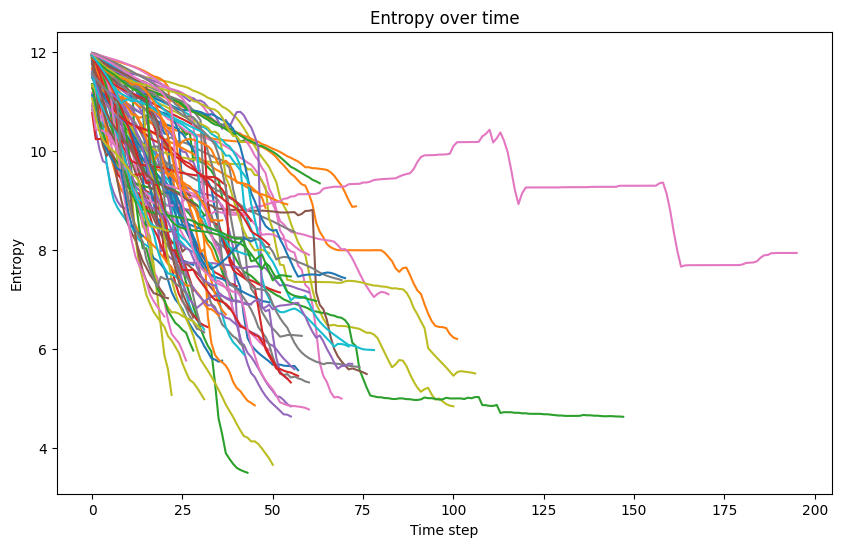

In [11]:
def plot_entropy(entropy):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,6))
    for i in range(len(entropy)):
        plt.plot(entropy[i])

    plt.xlabel('Time step')
    plt.ylabel('Entropy')
    plt.title('Entropy over time')

plot_entropy(entropy)

In [12]:
reached_goal = 0
truncated_index = []
for i, ep in enumerate(transitions):
    if ep[-1][-2] == True:
        reached_goal += 1
    else:
        truncated_index.append(i)
print("Target reached", reached_goal, "out of", len(transitions), "episodes")    

# check the mean reward
mean_reward = 0
for i, ep in enumerate(transitions):
    if i in truncated_index:
        continue
    mean_reward += sum([t[2] for t in ep])
mean_reward /= len(transitions)
print("Mean episode Reward: ", mean_reward)

# check the mean number of steps
mean_steps = 0
for i, ep in enumerate(transitions):
    if i in truncated_index:
        continue
    mean_steps += len(ep)
mean_steps /= len(transitions)
print("Mean number of steps: ", mean_steps)


Target reached 100 out of 100 episodes
Mean episode Reward:  -29.575
Mean number of steps:  45.83


# Discrete vs VI

In [160]:
OBSERVATION_TYPE = 'single' # OR 'cardinal'
RENDER_MODE = 'human' # OR 'rgb_array'
BELIEF_UPDATE = 'discrete' # OR 'variational'
DISCRETIZATION = 20
DEBUG = True

obs_model = load_obs_model(OBSERVATION_TYPE)

pomdp_env = POMDPDeformedGridworld(obs_type=OBSERVATION_TYPE, render_mode=RENDER_MODE)
agent = POMDPAgent(model, pomdp_env, update=BELIEF_UPDATE, obs_model=obs_model,discretization=DISCRETIZATION, debug=DEBUG)


Discrete belief update with observation model - SHEAR allowed
Using discrete belief update method


In [172]:
pomdp_env.reset()

stretch, shear = [pomdp_env.transformation_matrix[0][0], pomdp_env.transformation_matrix[1][1]],[pomdp_env.transformation_matrix[0][1], pomdp_env.transformation_matrix[1][0]]
starting_pos = pomdp_env.get_state()['pos']

print("Starting position: ", starting_pos)
print("Deformation: ", pomdp_env.transformation_matrix)

Starting position:  tensor([0.5784, 0.6159])
Deformation:  [[0.8634555756206257, 0.0845220000964112], [0.05222726762116381, 0.6452559014065177]]


In [168]:
while True:
    try:
        action, _  = agent.predict(pomdp_env.get_state(), deterministic=False)
        _, _ , terminated, truncated, _ = pomdp_env.step(action)
        pomdp_env.render()
        if terminated or truncated:
            break
    except:
        break
pomdp_env.close()   

In [169]:
OBSERVATION_TYPE = 'single' # OR 'cardinal'
RENDER_MODE = 'human' # OR 'rgb_array'
BELIEF_UPDATE = 'variational' # OR 'variational'
DISCRETIZATION = 20
DEBUG = True

obs_model = load_obs_model(OBSERVATION_TYPE)

pomdp_env = POMDPDeformedGridworld(obs_type=OBSERVATION_TYPE, render_mode=RENDER_MODE)
agent = POMDPAgent(model, pomdp_env, update=BELIEF_UPDATE, obs_model=obs_model,discretization=DISCRETIZATION, debug=DEBUG)


Using variational belief update method


In [170]:
pomdp_env.set_deformation(stretch, shear)
pomdp_env.set_position(starting_pos.tolist())

In [171]:
while True:
    try:
        action, _  = agent.predict(pomdp_env.get_state(), deterministic=False)
        _, _ , terminated, truncated, _ = pomdp_env.step(action)
        pomdp_env.render()
        if terminated or truncated:
            break
    except:
        break
pomdp_env.close()   

Epoch 10/10, Loss: 0.5515
Estimated theta mean: tensor([ 0.7093, -0.0317, -0.0182,  0.6607])
Epoch 10/10, Loss: 0.6743
Estimated theta mean: tensor([ 0.7510,  0.0028, -0.0232,  0.6189])
Epoch 10/10, Loss: 0.5720
Estimated theta mean: tensor([ 0.7169, -0.0201, -0.0230,  0.6096])
Epoch 10/10, Loss: 0.7081
Estimated theta mean: tensor([ 0.7471,  0.0025, -0.0294,  0.5540])
Epoch 10/10, Loss: 0.7943
Estimated theta mean: tensor([ 0.7361,  0.0050, -0.0055,  0.5539])
Epoch 10/10, Loss: 1.1203
Estimated theta mean: tensor([ 0.7425,  0.0372, -0.0172,  0.5542])
Epoch 10/10, Loss: 1.2000
Estimated theta mean: tensor([0.7378, 0.0196, 0.0108, 0.5777])
Epoch 10/10, Loss: 1.6623
Estimated theta mean: tensor([0.7685, 0.0458, 0.0126, 0.6076])
Epoch 10/10, Loss: 1.4522
Estimated theta mean: tensor([ 0.7840,  0.0439, -0.0387,  0.5477])
Epoch 10/10, Loss: 1.8325
Estimated theta mean: tensor([ 0.7833,  0.0513, -0.0667,  0.5059])
Epoch 10/10, Loss: 2.6119
Estimated theta mean: tensor([ 0.7916,  0.0519, -0.0